First code block is just to start up the JVM

In [1]:
from jpype import *
import numpy
import sys
# Our python data file readers are a bit of a hack, python users will do better on this:
sys.path.append("/home/joseph/JIDT/infodynamics-dist-1.6.1/demos/python")
import readIntsFile

if (not isJVMStarted()):
    # Add JIDT jar library to the path
    jarLocation = "/home/joseph/JIDT/infodynamics-dist-1.6.1/infodynamics.jar"
    # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation, convertStrings=True)

Next load in the data, and check that we can pull out a sample digit ok.

We give code for two options to load the data, either:
* Via the Matlab pre-processed `.mat` file, or
* Using the `torch` package (may also require `torchvision`) to automatically download the data and load it (_default_)

The data is loaded into numpy arrays, being:
* `classes` -- a 1D array of the classes 0..9 for each sample;
* `pixels1D` -- binarised pixel data for each sample, with dimensions (numTrials, imageDimension * imageDimension) -- i.e. one dimensional data for each sample. (This is the usual JIDT multivariate data format, with each row being a sample, and each column a variable).
* `pixels2D` -- binarised pixel data for each sample, with dimensions (numTrials, imageDimension, imageDimension) -- i.e. two dimensional image data for each sample.

You can work with whichever of `pixels1D` or `pixels2D` that you prefer.

Loaded MNIST data with 70000 samples, classes 0:9, and 784 pixels per sample



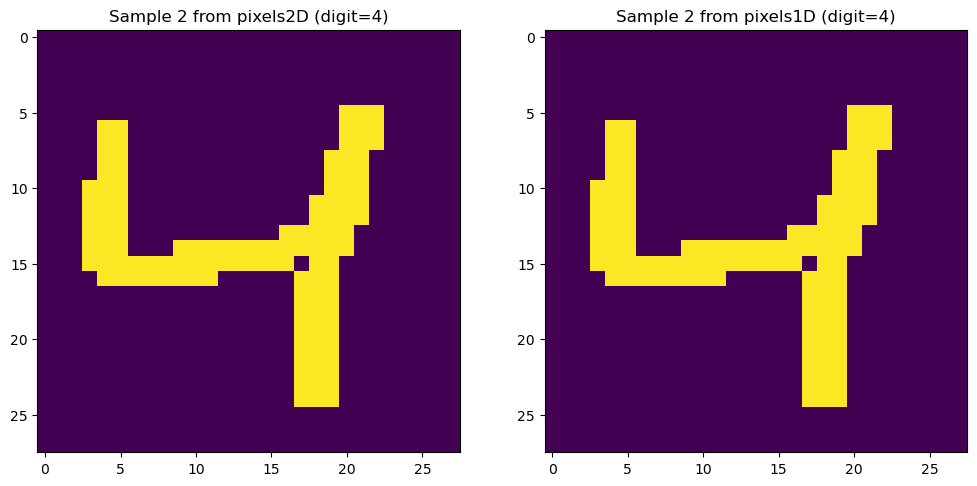

In [2]:
# Load/prepare the data:

# Choose whether to import via torch or via the distributed Matlab format:
downloadViaTorch = True

if (not(downloadViaTorch)):
    # Option 1: import the pre-prepared data in Matlab format:
    import scipy.io
    data = scipy.io.loadmat('/home/joseph/TeachingPlayground/CSYS5030/Week8/MNIST/trialAndTest-processedData.mat');
    trainAndTestData = numpy.array(data['trialAndTestData'])
    classes = trainAndTestData[:,0] - 1; # Need classes to start from 0 for JIDT (and it's sensible to match digits here also)
    rawPixels1D = trainAndTestData[:,1:];
    numPixels = rawPixels1D.shape[1];
    numTrials = rawPixels1D.shape[0];
    import math
    imageDimension = int(math.sqrt(numPixels)); # Will be 28
    rawPixels2D = numpy.reshape(rawPixels1D, (numTrials, imageDimension, imageDimension));
else:
    # Option 2: automatically download (into local folder 'data') and import the data using torchvision:
    #  (thanks to Isabelle De Backer for pointing this option out)
    import torchvision
    trainData = torchvision.datasets.MNIST('./data', download=True, train=True)
    testData = torchvision.datasets.MNIST('./data', download=True, train=False)
    rawPixels2D = numpy.row_stack((trainData.data, testData.data))
    imageDimension = rawPixels2D.shape[1];
    numPixels = imageDimension * imageDimension;
    numTrials = rawPixels2D.shape[0];
    rawPixels1D = numpy.reshape(rawPixels2D, (numTrials, imageDimension * imageDimension))
    classes = numpy.concatenate((trainData.targets, testData.targets))

numClasses = 10; # We know we only have digits 0-9 here
print('Loaded MNIST data with %d samples, classes %d:%d, and %d pixels per sample\n' %\
    (numTrials, min(classes), max(classes), numPixels));

# Binarise the pixel data:
threshold = 15; # From viewing histograms of pixel values this seems reasonable.
pixels2D = rawPixels2D > threshold; # In dimensions (numTrials, imageDimension, imageDimension) 
pixels1D = rawPixels1D > threshold; # In dimensions (numTrials, imageDimension * imageDimension)

# And check that we can plot of of the images ok from either the 1D or 2D arrangements:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1,2,1) # left subplot
sampleIndex = 2;
plt.imshow( pixels2D[sampleIndex,:,:] ) # Plotting the 3rd digit as a sample
plt.title('Sample %d from pixels2D (digit=%d)' % (sampleIndex, classes[sampleIndex]));
plt.subplot(1, 2, 2); # right one
plt.imshow( numpy.reshape(pixels1D[sampleIndex,:], (imageDimension, imageDimension) )) # Plotting the 3rd digit as a sample
plt.title('Sample %d from pixels1D (digit=%d)' % (sampleIndex, classes[sampleIndex]));

# Analysis 1 -- compute the MI from each pixel to the digit class:

In this sample analysis we compute the MI from each pixel to the digit class:

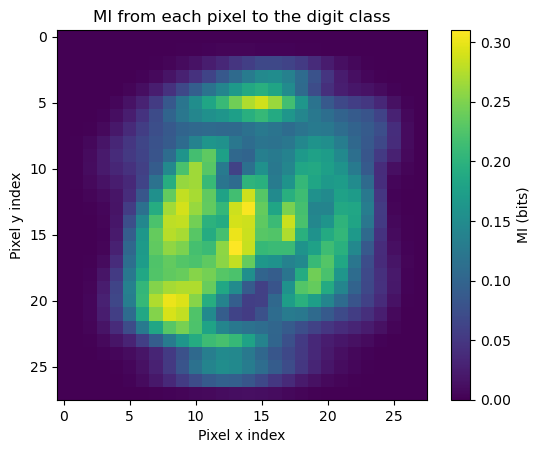

In [3]:
mis = numpy.zeros((numPixels));

for p in range(numPixels):
    # 1. Construct the calculator:
    calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
    calc = calcClass(2, 10, 0) # MI from binary pixel to class (alphabet size 10)
    # 2. No other properties to set for discrete calculators.
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    # 4. Supply the sample data: need to convert the pixels ready for Java:
    calc.addObservations(JArray(JInt, 1)(pixels1D[:,p].tolist()), JArray(JInt, 1)(classes.astype(int).tolist()))
    # 5. Compute the estimate:
    mis[p] = calc.computeAverageLocalOfObservations()

# Plot the MI from each pixel to the digit class:
plt.imshow( numpy.reshape(mis, (imageDimension, imageDimension)) ) # Reshaping the same way as above
plt.xlabel('Pixel x index');
plt.ylabel('Pixel y index');
cbar = plt.colorbar()
cbar.set_label('MI (bits)');
plt.title('MI from each pixel to the digit class');

# Analysis 2 -- compute the MI from each pixel to the digit class:

In this sample analysis we compute the MI from each pixel to the digit class, but we do this in a partially pointwise fashion for each digit, i.e.:

I(Pixel; digit=0) = \mean_{digit == 0) { i(pixel ; digit }

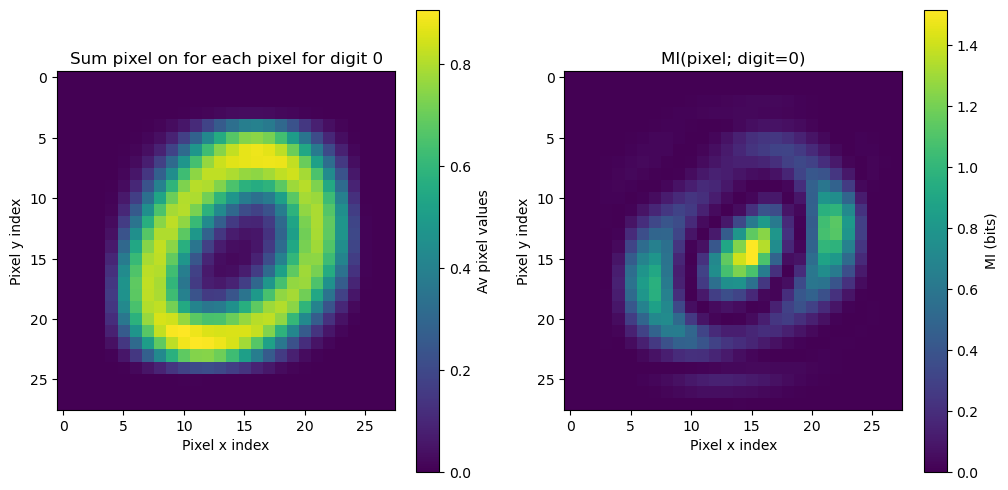

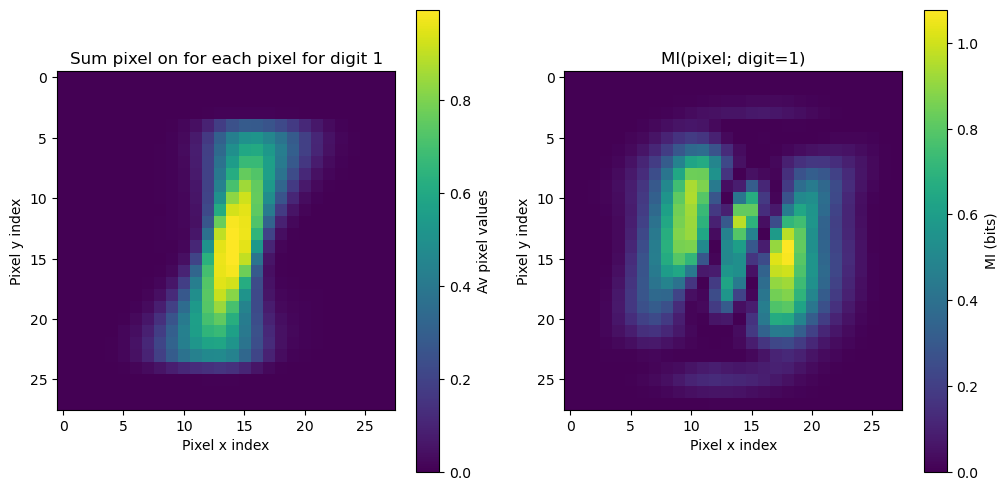

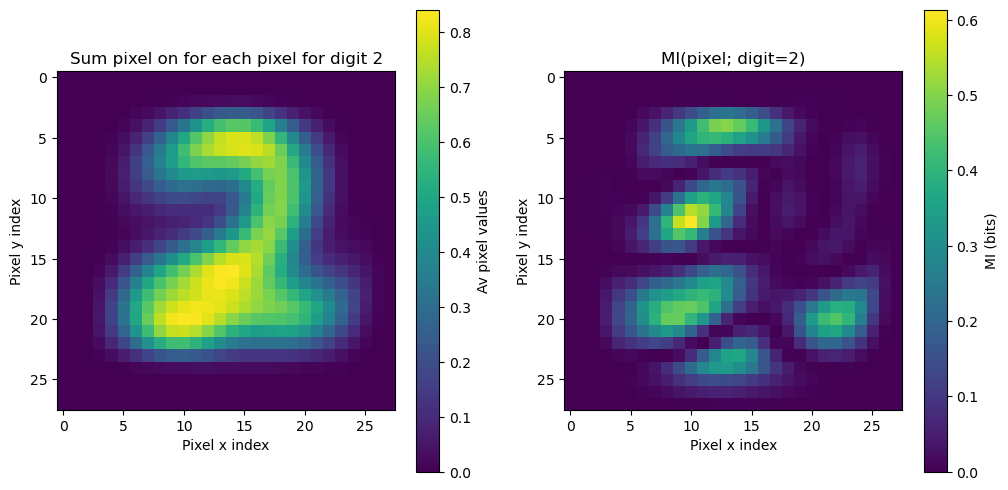

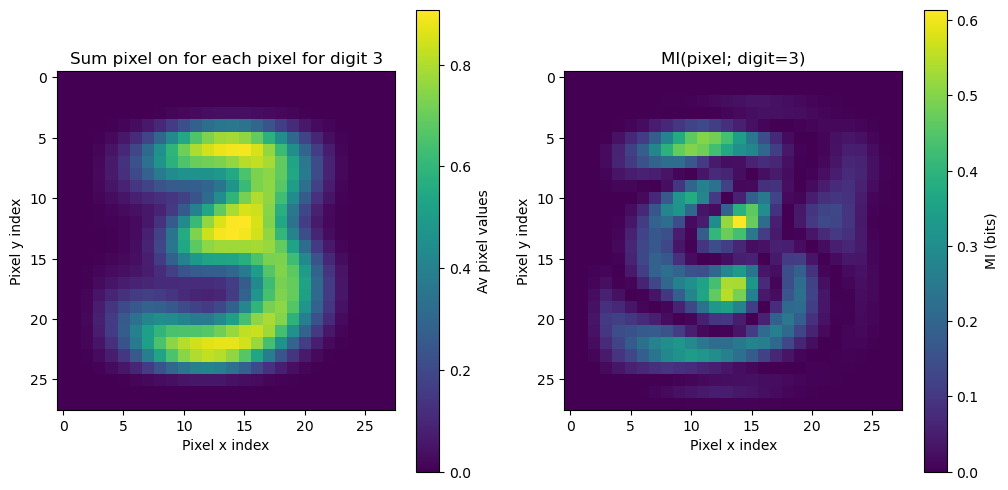

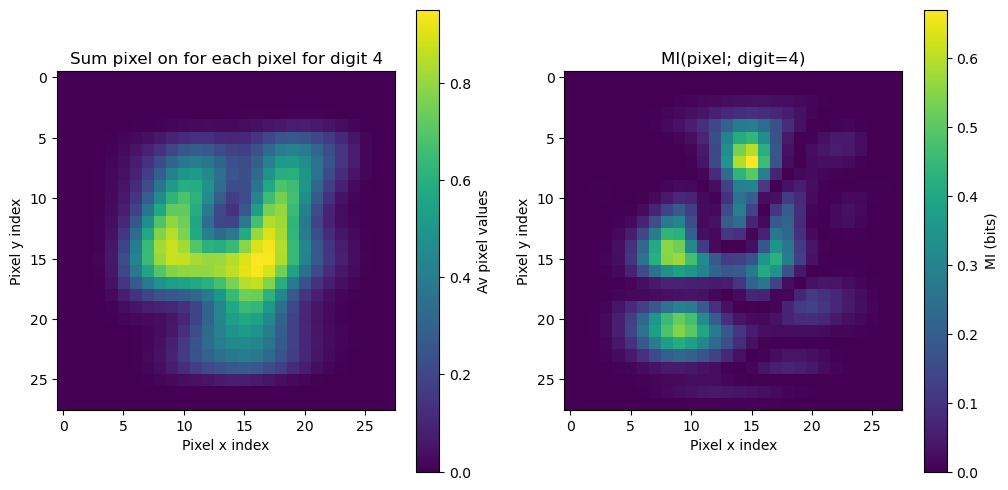

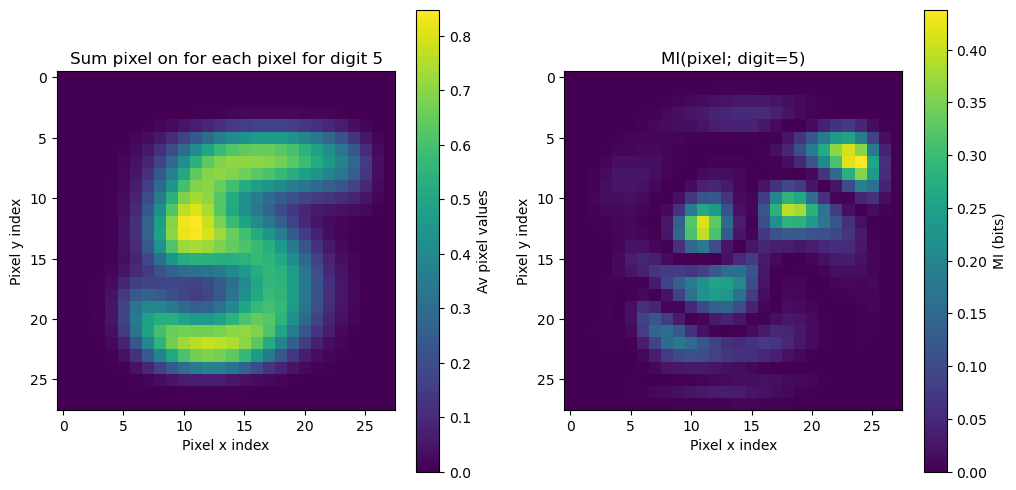

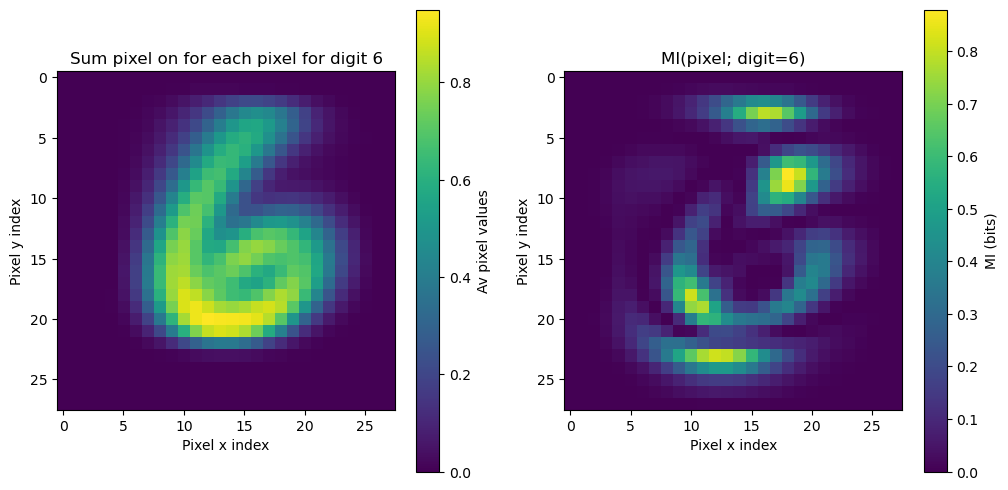

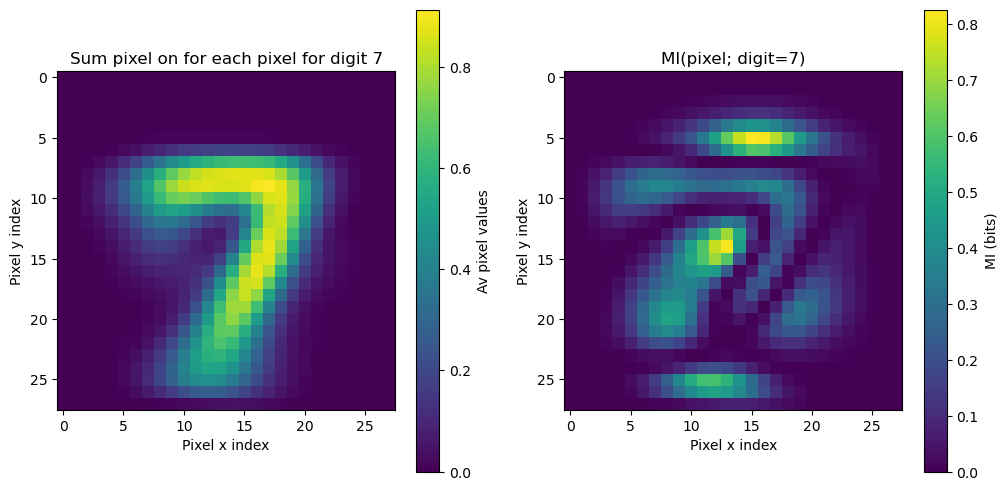

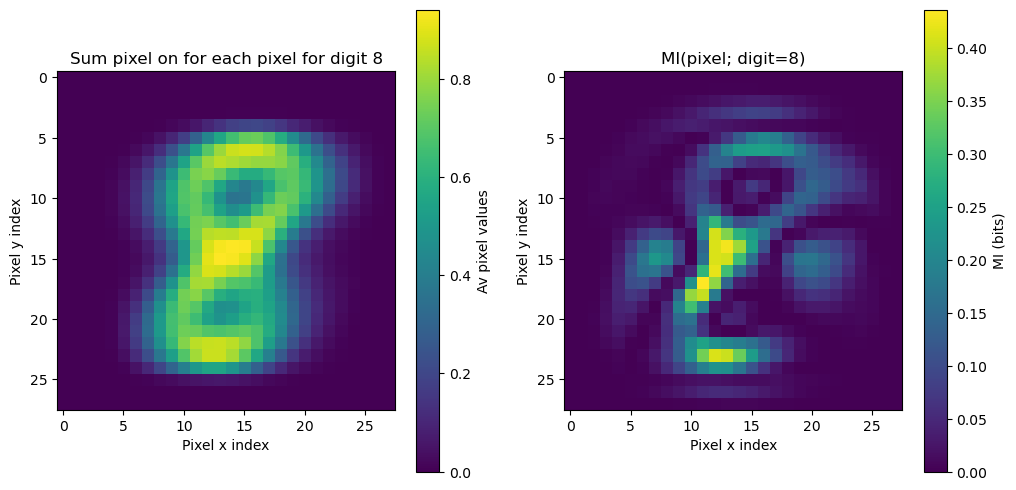

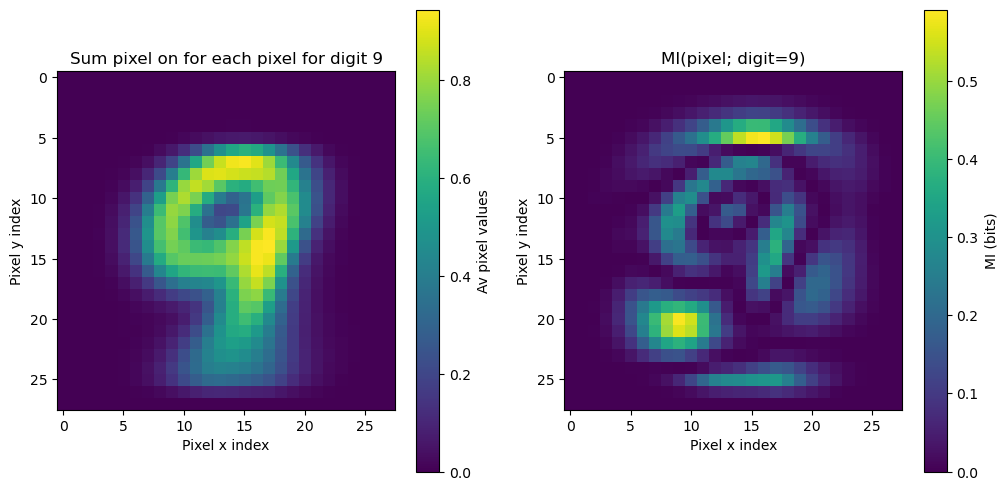

In [4]:
mis = numpy.zeros((numPixels));
misPointwisePerPixel = numpy.zeros((numTrials, numPixels));

for p in range(numPixels):
    # 1. Construct the calculator:
    calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
    calc = calcClass(2, 10, 0) # MI from binary pixel to class (alphabet size 10)
    # 2. No other properties to set for discrete calculators.
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    # 4. Supply the sample data: need to convert the pixels ready for Java:
    calc.addObservations(JArray(JInt, 1)(pixels1D[:,p].tolist()), JArray(JInt, 1)(classes.astype(int).tolist()))
    # 5. Compute the estimate: grab the local values per pixel this time
    mis[p] = calc.computeAverageLocalOfObservations()
    misPointwisePerPixel[:,p] = calc.computeLocalFromPreviousObservations(JArray(JInt, 1)(pixels1D[:,p].tolist()), JArray(JInt, 1)(classes.astype(int).tolist()));

# Now average the pointwise values for each digit for each pixel and plot
# them:
for digit in range(10):
    # Average the pointwise values for this pixel for this digit.
    # We have this digit when classes == digit --
    misPointwiseForEachPixel = numpy.sum(misPointwisePerPixel[classes == digit,:],0) / numpy.sum(classes == digit);

    plt.figure(figsize=(12,6))
    # First plot the average pixel values for this digit:
    plt.subplot(1,2,1) # left subplot
    avPixelValues = numpy.sum(pixels1D[classes == digit,:],0) / sum(classes == digit);
    plt.imshow( numpy.reshape(avPixelValues, (imageDimension, imageDimension)) ) # Reshaping the same way as above
    plt.xlabel('Pixel x index');
    plt.ylabel('Pixel y index');
    cbar = plt.colorbar()
    cbar.set_label('Av pixel values');
    plt.title('Sum pixel on for each pixel for digit %d' % digit);
    
    # Plot the MI from each pixel to the digit class:
    plt.subplot(1, 2, 2); # right one
    plt.imshow( numpy.reshape(misPointwiseForEachPixel, (imageDimension, imageDimension)) ) # Reshaping the same way as above
    plt.xlabel('Pixel x index');
    plt.ylabel('Pixel y index');
    cbar = plt.colorbar()
    cbar.set_label('MI (bits)');
    plt.title('MI(pixel; digit=%d)' % digit);

    plt.show()
